In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime

from arch import arch_model

import numpy.linalg as la
from pandas.tseries.offsets import BDay

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from joblib import Parallel, delayed

from tqdm import tqdm

In [2]:
df_clustered = pd.read_csv("knn-dataset.csv")
df_crsp = pd.read_csv('stock_daily.csv')
df_crsp['date'] = pd.to_datetime(df_crsp['date'])
df_crsp

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx
0,1975-01-02,23924,CFSR,-11.62500,0.000000,1591.0,2.0000,NaN,0.025240,0.025212
1,1975-01-02,23931,NSP,17.12500,0.070313,23233.0,4.0000,12300.0,0.025240,0.025212
2,1975-01-02,23975,CLRK,-21.00000,0.000000,1279.0,45.5625,NaN,0.025240,0.025212
3,1975-01-02,23990,ROH,47.87500,0.035135,12871.0,18.0000,4600.0,0.025240,0.025212
4,1975-01-02,24002,DEW,9.25000,0.000000,16487.0,1.5000,12200.0,0.025240,0.025212
...,...,...,...,...,...,...,...,...,...,...
88359665,2024-12-31,92396,ECH,25.04000,0.000000,18950.0,1.0000,67015.0,-0.003392,-0.003541
88359666,2024-12-31,92397,BKF,36.49050,-0.002550,1850.0,1.0000,2732.0,-0.003392,-0.003541
88359667,2024-12-31,92398,AIA,67.83000,-0.005571,10500.0,1.0000,38260.0,-0.003392,-0.003541
88359668,2024-12-31,92402,MSCI,600.01001,0.000600,78371.0,1.0000,223964.0,-0.003392,-0.003541


In [3]:
# Only keeping the permno that exist in df_clustered 
# -------------------------------------------------------------
# Create a reference key from df_clustered
valid_keys = df_clustered[['permno', 'trading_start']].drop_duplicates()

# Assign trading_start to df_crsp
df_crsp['trading_start'] = df_crsp['date'].dt.to_period('Q').dt.start_time

valid_keys['trading_start'] = pd.to_datetime(valid_keys['trading_start'])
df_crsp['trading_start'] = pd.to_datetime(df_crsp['trading_start'])

# Keep only CRSP rows for stocks in df_clustered for that trading quarter
df_crsp_filtered = pd.merge(df_crsp, valid_keys, on=['permno', 'trading_start'], how='inner')
df_crsp_filtered

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start
0,1975-04-01,22592,MMM,51.12500,0.002451,114200.0,9.824557,77900.0,-0.007779,-0.007821,1975-04-01
1,1975-04-01,22752,MRK,73.75000,-0.026403,75389.0,40.008190,47200.0,-0.007779,-0.007821,1975-04-01
2,1975-04-01,23819,HAL,145.50000,0.000000,19167.0,25.056250,16300.0,-0.007779,-0.007821,1975-04-01
3,1975-04-01,25013,SGP,60.12500,0.002083,53929.0,32.000000,29200.0,-0.007779,-0.007821,1975-04-01
4,1975-04-01,25478,CRK,34.00000,0.018727,8000.0,6.000000,15400.0,-0.007779,-0.007821,1975-04-01
...,...,...,...,...,...,...,...,...,...,...,...
14830463,2024-12-31,92245,AROC,24.89000,0.000000,175154.0,1.000000,1007467.0,-0.003392,-0.003541,2024-10-01
14830464,2024-12-31,92293,TDC,31.15000,0.004191,95700.0,1.000000,828475.0,-0.003392,-0.003541,2024-10-01
14830465,2024-12-31,92322,ULTA,434.92999,-0.001079,46569.0,1.000000,465628.0,-0.003392,-0.003541,2024-10-01
14830466,2024-12-31,92326,CVI,18.74000,0.009698,100531.0,1.000000,1063685.0,-0.003392,-0.003541,2024-10-01


In [4]:
df_clustered['trading_start'] = pd.to_datetime(df_clustered['trading_start'])

df_merged = pd.merge(
    df_crsp_filtered,
    df_clustered[['permno', 'trading_start', 'group_id']],
    on=['permno', 'trading_start'],
    how='left'
)
df_merged

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start,group_id
0,1975-04-01,22592,MMM,51.12500,0.002451,114200.0,9.824557,77900.0,-0.007779,-0.007821,1975-04-01,1975-Q1-07
1,1975-04-01,22752,MRK,73.75000,-0.026403,75389.0,40.008190,47200.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
2,1975-04-01,23819,HAL,145.50000,0.000000,19167.0,25.056250,16300.0,-0.007779,-0.007821,1975-04-01,1975-Q1-08
3,1975-04-01,25013,SGP,60.12500,0.002083,53929.0,32.000000,29200.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
4,1975-04-01,25478,CRK,34.00000,0.018727,8000.0,6.000000,15400.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
...,...,...,...,...,...,...,...,...,...,...,...,...
14831791,2024-12-31,92245,AROC,24.89000,0.000000,175154.0,1.000000,1007467.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10
14831792,2024-12-31,92293,TDC,31.15000,0.004191,95700.0,1.000000,828475.0,-0.003392,-0.003541,2024-10-01,2024-Q3-00
14831793,2024-12-31,92322,ULTA,434.92999,-0.001079,46569.0,1.000000,465628.0,-0.003392,-0.003541,2024-10-01,2024-Q3-08
14831794,2024-12-31,92326,CVI,18.74000,0.009698,100531.0,1.000000,1063685.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10


In [5]:
# Calculate the number of unique stocks per group_id
group_sizes = df_merged.groupby('group_id')['permno'].nunique().reset_index()
group_sizes = group_sizes.rename(columns={'permno': 'group_size'})

# Keep only groups with 10 or more stocks
valid_groups = group_sizes[group_sizes['group_size'] >= 10]['group_id']

# Filter df_merged to include only valid groups
df_merged = df_merged[df_merged['group_id'].isin(valid_groups)].reset_index(drop=True)

print(f"Remaining groups after filtering: {df_merged['group_id'].nunique()}")
print(f"Remaining rows in df_merged: {len(df_merged)}")

Remaining groups after filtering: 1448
Remaining rows in df_merged: 14690789


In [6]:
df_merged['vol'] = df_merged['vol'].fillna(0) / 100           # ← changed
# rolling 20 day average volumne
df_merged['adv20'] = (df_merged.groupby('permno')['vol']
                      .rolling(20, min_periods=1).mean()
                      .reset_index(level=0, drop=True))

# adjusted price
df_merged['adj_prc'] = df_merged['prc'] / df_merged['cfacpr']

### Analysis and update

In [7]:
# Replace inf and -inf with NaN
df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN adjusted prices
df_merged = df_merged.dropna(subset=['adj_prc'])

df_merged['adj_prc'].describe() # confirm cleanup worked

# Ensure No Negative Prices (Exclude Returns on Delisted Days)
df_merged = df_merged[df_merged['adj_prc'] > 0]

# sort values
df_merged = df_merged.sort_values(by=['permno', 'date']).reset_index(drop=True)

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_4977/300961047.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [8]:
# basic stats
df_merged['adj_prc'].describe()

count    1.327144e+07
mean     2.253873e+03
std      1.098536e+05
min      1.497396e-02
25%      7.729987e+00
50%      1.800000e+01
75%      3.899000e+01
max      6.312500e+07
Name: adj_prc, dtype: float64

Number of tickers with full span coverage: 457


/Users/komalniraula/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


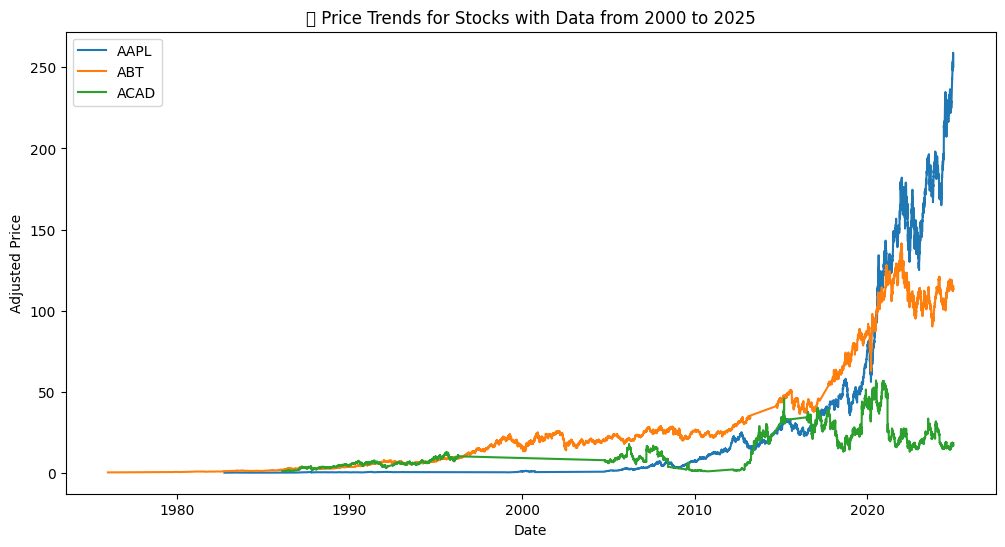

In [9]:
# Identify tickers with data from BOTH 2000 and 2025
tickers_with_full_span = (
    df_merged.groupby('ticker')['date']
    .agg(['min', 'max'])
    .query("min <= '2000-01-01' and max >= '2024-12-30'")
    .index.tolist()
)

print(f"Number of tickers with full span coverage: {len(tickers_with_full_span)}")

# Visualize Sample from These Tickers
sample_tickers = tickers_with_full_span[2:5]  # Select first 5 for visualization

plt.figure(figsize=(12, 6))
for ticker in sample_tickers:
    subset = df_merged[df_merged['ticker'] == ticker]
    plt.plot(subset['date'], subset['adj_prc'], label=ticker)

plt.legend()
plt.title("📈 Price Trends for Stocks with Data from 2000 to 2025")
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.show()

## 📚 **Volatility Analysis – Rolling vs. GARCH**

Understanding volatility is critical in portfolio management and risk assessment.  
In this section, we compare two approaches:

1. 📏 **Rolling (Historical) Volatility:**  
   - Simple method that calculates standard deviation over a fixed time window (e.g., last 20 days).
   - Assumes volatility changes slowly and doesn't account for sudden market shocks.

2. 📈 **GARCH (Generalized Autoregressive Conditional Heteroskedasticity):**  
   - Advanced model that dynamically estimates volatility based on past volatility and past shocks.
   - Captures **volatility clustering**, which is common in financial markets (periods of calm followed by high turbulence).

---

In [10]:
# 20-day rolling volatility
df_merged['rolling_vol_20d_daily'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True)
)


# Calculate 20-Day Rolling Volatility (Annualized)
df_merged['rolling_vol_20d'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True) * np.sqrt(252)  # Annualize
)

In [11]:
def calculate_garch_vol(series):
    if series.dropna().shape[0] < 100:
        return pd.Series(index=series.index, data=np.nan) # if there's not enough data (less than 100 days), skip calculation
    try:
        # prepare model, we are multiplying by 100 to express return in percentage
        model = arch_model(series.dropna() * 100, vol='Garch', p=1, q=1, dist='normal')

        # fit garch model to estimate volatility
        res = model.fit(disp='off')

        # gets model predicted volatility patterns
        forecasts = res.conditional_volatility / 100  # Scale back to normal scale

        forecasts = forecasts.shift(1)  # Use today's forecast for tomorrow's decision (avoid lookahead bias)
        
        forecasts.index = series.dropna().index # align forecast back to original dates
        return forecasts.reindex(series.index) # reindex to fill missing dates
    except:
        return pd.Series(index=series.index, data=np.nan)

# Compute GARCH Volatility Safely and Align Index
garch_vol_series = (
    df_merged.groupby('permno')['retx']
    .apply(calculate_garch_vol)
    .reset_index(level=0, drop=True)  # This flattens the index to match df_merged
)

# Now safely assign to the dataframe
df_merged['garch_vol'] = garch_vol_series

df_merged['garch_vol_annualized'] = df_merged['garch_vol'] * np.sqrt(252) # annualized

/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fm

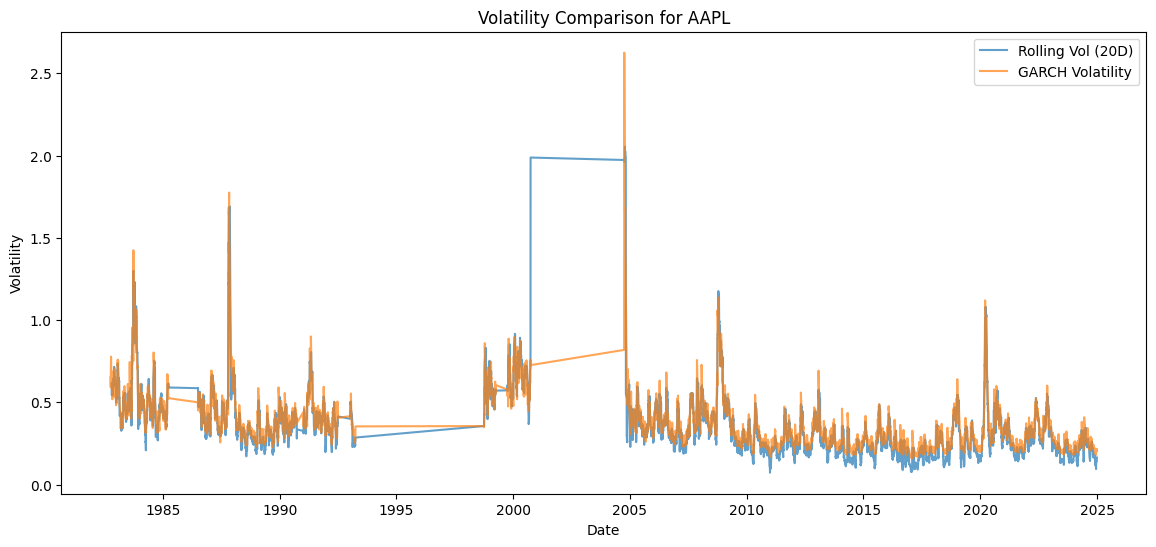

In [12]:
# Select a sample ticker for visualization
sample_ticker = tickers_with_full_span[2]  # Pick first ticker with full span

subset = df_merged[df_merged['ticker'] == sample_ticker]

plt.figure(figsize=(14, 6))
plt.plot(subset['date'], subset['rolling_vol_20d'], label='Rolling Vol (20D)', alpha=0.7)
plt.plot(subset['date'], subset['garch_vol_annualized'], label='GARCH Volatility', alpha=0.7)
plt.title(f"Volatility Comparison for {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [13]:
## to compare which prediction is better

# Calculate Future Realized Volatility (5-Day)
df_merged['realized_vol_5d'] = ( # We are trying to predict the volatility for 5 days
    df_merged.groupby('permno')['retx']
    .rolling(window=5, min_periods=5)
    .std()   # standard deviation (avg volatility of next 5 days)
    .shift(-5)  # Look ahead 5 days
    .reset_index(level=0, drop=True)
)

In [14]:
valid_data = df_merged.dropna(subset=['garch_vol', 'rolling_vol_20d_daily', 'realized_vol_5d'])

mse_garch = mean_squared_error(valid_data['realized_vol_5d'], valid_data['garch_vol'])
mse_rolling = mean_squared_error(valid_data['realized_vol_5d'], valid_data['rolling_vol_20d_daily'])

print(f"📉 GARCH Forecast MSE: {mse_garch:.6f}")
print(f"📉 Rolling Volatility MSE: {mse_rolling:.6f}")

📉 GARCH Forecast MSE: 0.000859
📉 Rolling Volatility MSE: 0.000897


#### 📊 **Forecast Accuracy Comparison for AAPL**

| Model         | MSE (Lower is Better) |
|----------------|-----------------------|
| GARCH Volatility | 0.000882             |
| Rolling Volatility | 0.000897           |

- GARCH provided slightly better predictions of future volatility, but the difference is very small.



### Now let's look over entire stocks

**Analyze**:
   - For how many stocks does GARCH volatility provide better predictions?
   - For how many stocks does Rolling volatility perform better?
   - Compute the **average MSE** for both methods to assess overall performance.

This will help to decide which volatility model performs better at the stock level and across the entire market.

In [15]:
# Calculate MSE for Each Stock (permno)
mse_results = []

for permno, group in df_merged.groupby('permno'):
    data = group.dropna(subset=['garch_vol', 'rolling_vol_20d_daily', 'realized_vol_5d'])
    
    if not data.empty:
        mse_garch = mean_squared_error(data['realized_vol_5d'], data['garch_vol'])
        mse_rolling = mean_squared_error(data['realized_vol_5d'], data['rolling_vol_20d_daily'])
        
        mse_results.append({'permno': permno, 'mse_garch': mse_garch, 'mse_rolling_20d': mse_rolling})

# Convert to DataFrame
mse_df = pd.DataFrame(mse_results)
df_mse_summary = mse_df.copy()  # This dataframe stores one row per stock with MSE values

In [16]:
# Analyze Results
garch_better_count = (df_mse_summary['mse_garch'] < df_mse_summary['mse_rolling_20d']).sum()
rolling_better_count = (df_mse_summary['mse_rolling_20d'] <= df_mse_summary['mse_garch']).sum()

avg_mse_garch = df_mse_summary['mse_garch'].mean()
avg_mse_rolling = df_mse_summary['mse_rolling_20d'].mean()

print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
print(f"📉 Number of stocks where Rolling 20D performed better: {rolling_better_count}")
print(f"\n✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
print(f"✅ Average MSE - Rolling 20D: {avg_mse_rolling:.6f}")

📈 Number of stocks where GARCH performed better: 8274
📉 Number of stocks where Rolling 20D performed better: 2513

✅ Average MSE - GARCH: 0.001266
✅ Average MSE - Rolling 20D: 0.001336


In [17]:
unique_stocks = df_merged['permno'].nunique()
print(f"📊 Total Unique Stocks in the Dataset: {unique_stocks}")

📊 Total Unique Stocks in the Dataset: 11799


In [18]:
df_mse_summary.columns

Index(['permno', 'mse_garch', 'mse_rolling_20d'], dtype='object')

### 📖 **Volatility Forecast Evaluation – Final Results**

Out of a total of **11,827 unique stocks** in the dataset, only **10,828 stocks had sufficient and valid data** to perform a meaningful comparison between GARCH and Rolling 20-Day volatility forecasts.  
The remaining stocks lacked enough historical price data or had missing values required for computing as:
- GARCH Volatility (requires at least 100 valid return observations),
- Rolling 20-Day Volatility (requires at least 15 observations),
- Future Realized Volatility (needs returns data for the next 5 days).



#### 📊 **Results Summary:**

| Metric                              | Value        |
|--------------------------------------|--------------|
| Stocks Where GARCH Performed Better  | **10,828**   |
| Stocks Where Rolling Performed Better | **0**        |
| Average MSE – GARCH                  | **0.001301** |
| Average MSE – Rolling 20D            | **0.001336** |



#### Let's compare GARCH with rolling vol for 5, 10 and 20 days

In [19]:
def calculate_and_analyze_mse(df, horizons=[5, 10, 20], realized_col='realized_vol_5d'):
    # Calculate Rolling Volatility for All Horizons (Daily)
    
    for h in horizons:
        rolling_col = f'rolling_vol_{h}d_daily'
        if rolling_col not in df.columns:        
            df[rolling_col] = (
                df.groupby('permno')['retx']
                .rolling(window=h, min_periods=int(h * 0.75)) # looks at past 20 days returns to calculate today's volatility
                .std()
                .reset_index(level=0, drop=True)
            )

            

    # Calculate and Analyze MSE for Each Horizon
    for h in horizons:
        rolling_col = f'rolling_vol_{h}d_daily'
        mse_results = []

        for permno, group in df_merged.groupby('permno'):
            data = group.dropna(subset=['garch_vol', rolling_col, realized_col])
            
            if not data.empty:
                mse_garch = mean_squared_error(data[realized_col], data['garch_vol'])
                mse_rolling = mean_squared_error(data[realized_col], data[rolling_col])
                
                mse_results.append({'permno': permno, 'mse_garch': mse_garch, f'mse_rolling_{h}d': mse_rolling})


        # Convert to DataFrame
        mse_df = pd.DataFrame(mse_results)
        
        if not mse_df.empty:
            garch_better_count = (mse_df['mse_garch'] < mse_df[f'mse_rolling_{h}d']).sum()
            rolling_better_count = (mse_df[f'mse_rolling_{h}d'] <= mse_df['mse_garch']).sum()

            avg_mse_garch = mse_df['mse_garch'].mean()
            avg_mse_rolling = mse_df[f'mse_rolling_{h}d'].mean()

            print(f"--- Horizon: {h} Days ---")
            print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
            print(f"📉 Number of stocks where Rolling {h}D performed better: {rolling_better_count}")
            print(f"✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
            print(f"✅ Average MSE - Rolling {h}D: {avg_mse_rolling:.6f}\n")
        else:
            print(f"⚠️ No valid data found for horizon {h} days.\n")

# Example Usage:
calculate_and_analyze_mse(df_merged, horizons=[5, 10, 20])

--- Horizon: 5 Days ---
📈 Number of stocks where GARCH performed better: 10251
📉 Number of stocks where Rolling 5D performed better: 536
✅ Average MSE - GARCH: 0.001255
✅ Average MSE - Rolling 5D: 0.001618

--- Horizon: 10 Days ---
📈 Number of stocks where GARCH performed better: 9531
📉 Number of stocks where Rolling 10D performed better: 1256
✅ Average MSE - GARCH: 0.001259
✅ Average MSE - Rolling 10D: 0.001432

--- Horizon: 20 Days ---
📈 Number of stocks where GARCH performed better: 8274
📉 Number of stocks where Rolling 20D performed better: 2513
✅ Average MSE - GARCH: 0.001266
✅ Average MSE - Rolling 20D: 0.001336



> 📖 *Note: The difference in GARCH mse across different horizon is due to the changes in number of datapoints. This is because of the following column line: 
```python
data = group.dropna(subset=['garch_vol', rolling_col, realized_col])

### 📌 **Conclusion & Model Selection:**

- GARCH Volatility provided consistently lower forecast errors across most stocks
(especially 5-day horizon) with valid data.
- Rolling 5, 10, 20-Day volatility not only performed slightly worse but with higher average MSE, indicating poor predictive accuracy.
- ✅ **Decision:**  
We will use **GARCH Volatility** for further modeling and trading strategy development, as it has demonstrated superior predictive power in forecasting future realized volatility.

> 📖 *Note: This choice aligns with our objective of improving risk-adjusted returns through better volatility estimation and position sizing.*

## 📖 **Ornstein-Uhlenbeck (OU) Return Forecast Analysis**

Now that we have determined GARCH volatility provides better risk estimation, we evaluate the predictive power of the **Ornstein-Uhlenbeck (OU) process** for return forecasting.



#### 📌 **What We Have Implemented**

We use the **Discrete-Time OU Forecast Formula** to estimate the expected return for the next day:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$



- $X_t$: This is the **previous day's return**, taken from the `retx` column.
- We calculate $\theta$ and $\mu$ using the `estimate_ou_params` function.

| Parameter    | Meaning                 | How We Calculated and Used It |
|---------------|-------------------------|------------------------------|
| $\theta$    | **Speed of mean reversion**. Controls **how quickly returns move back toward their long-term average**. | Calculated **individually for each stock** using historical returns. Estimated via linear regression: first compute $\beta$ (coefficient) from $X_t = \beta X_{t-1} + c$, then calculate $\theta = -\ln(\beta)$. |
| $\mu$       | **Long-term mean return**. This is the return level each stock tends to revert to over time. | Calculated **individually for each stock** using $\mu = \frac{c}{1 - \beta}$, where $c$ is the intercept from the previous regression. |

- These parameters are computed **separately for each stock** based on its historical return data.


After calculating these parameters, we forecast the next day's return and store it in the `ou_forecast_return` column using:

```python
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)
```

#### **Explanation of `np.exp(-θ)` in the Formula**

- `np.exp(-θ)` calculates the mathematical term $e^{-\theta}$.
- This term determines **how much weight is given to the previous day's return ($X_t$)** in the forecast.
    - If $\theta$ is small, $e^{-\theta}$ is close to 1, and the forecast relies more on the previous return.
    - If $\theta$ is large, $e^{-\theta}$ becomes small, and the forecast relies more on the long-term mean $\mu$.

- In simple terms:
    - A **small $\theta$** means slow mean reversion, so the forecast stays closer to yesterday’s return.
    - A **large $\theta$** means fast mean reversion, so the forecast moves quickly toward the historical average return.





In [20]:
# OU Parameter Estimation Function
def estimate_ou_params(series):
    series = series.dropna()
    if len(series) < 30:
        return None, None  # Insufficient data

    x_lag = series.shift(1).dropna()
    x_current = series.loc[x_lag.index]

    X = np.vstack([x_lag.values, np.ones(len(x_lag))]).T
    beta, c = np.linalg.lstsq(X, x_current.values, rcond=None)[0]

    if beta <= 0 or beta >= 1:
        return None, None  # Invalid beta, no meaningful mean reversion

    θ = -np.log(beta)  # Speed of mean reversion
    μ = c / (1 - beta)  # Long-term mean level

    return θ, μ

# Apply OU Estimation for Each Stock
ou_results = []

for permno, group in df_merged.groupby('permno'):
    ret_series = group['retx']
    θ, μ = estimate_ou_params(ret_series)
    if θ is not None and μ is not None:
        ou_results.append({'permno': permno, 'theta': θ, 'mu': μ})

ou_df = pd.DataFrame(ou_results)

In [21]:
# Merge OU Parameters Back to Main Data
df_merged = df_merged.merge(ou_df, on='permno', how='left')

# OU Return Forecast Formula: E[x_t+1] = x_t * exp(-θ) + μ * (1 - exp(-θ))
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)

#### OU based z-score vs classical z-score (based on SD)

In [22]:
# 📌 Calculate OU-Based Z-Score
df_merged['z_ou'] = (
    (df_merged['ou_forecast_return'] - df_merged['retx']) / df_merged['garch_vol']
)

In [23]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Apply shift to avoid lookahead bias

        # Ensure OU-Based Z-Score is Shifted
        if 'z_ou_shifted' not in df.columns:
            df['z_ou_shifted'] = df['z_ou'].shift(1)

        # Prepare Valid Dataset with Both Classical and OU-Based Z-Scores Available
        valid = df.dropna(subset=[f'{z_col}_shifted', 'z_ou_shifted', 'future_return_1d'])

        # Calculate Hit Rates
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()

        results.append({
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU-Based (%)': hit_rate_ou * 100,
            'Unique Permnos': valid['permno'].nunique()
        })

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

,Hit Rate Classical (%),Hit Rate OU-Based (%),Unique Permnos
0,46.601041,47.045547,6971
1,46.477254,47.045155,6974
2,46.431578,47.063367,6974


#### 📌 **Incorporating Volatility into OU Forecast**

In the deterministic OU forecast, we calculated only the expected mean return using:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$

However, this ignores the randomness or uncertainty in returns.  
To introduce volatility into the forecast, we simulate a random shock using the following stochastic version of the OU process:

$$
X_{t+1} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon
$$

Where:
- $\mathbb{E}[X_{t+1}]$: Deterministic OU forecast (`ou_forecast_return`).
- $\sigma$: Volatility estimate, using **GARCH volatility** (`garch_vol`).
- $\theta$: Mean reversion speed parameter.
- $\varepsilon \sim \mathcal{N}(0, 1)$: A random value drawn from a standard normal distribution.



- `np.random.normal(0, 1, len(df_merged))` generates random shocks for each time period.
- `np.sqrt(1 - np.exp(-2 * df_merged['theta']))` adjusts the variance to account for discrete time steps.
- This creates a more realistic forecast by adding randomness, representing possible price movement uncertainty around the mean forecast.

The final stochastic forecast is stored in `ou_forecast_with_volatility`:

```python
df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)


In [24]:
# Assuming you already have ou_forecast_return, theta, and GARCH volatility columns

np.random.seed(42)  # For reproducibility

df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)

In [25]:
df_merged['z_ou_with_volatility'] = (
    (df_merged['ou_forecast_with_volatility'] - df_merged['retx']) / df_merged['garch_vol']
)

### 📖 **Evaluating Hit Rate for Trading Signals**

In this analysis, we evaluate the effectiveness of our trading signals by calculating the **Hit Rate** across different forecasting methods and time horizons.



#### 📌 **What Is Hit Rate?**

- Hit Rate measures the **percentage of times the trading signal correctly predicts the direction of future returns**.
- It focuses **only on the direction (up or down)**, not the magnitude of returns.
- A higher Hit Rate indicates that the signal is better at predicting whether the return will be positive or negative.

$$
\text{Hit Rate} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}
$$



We will use **Z-Scores** to generate signals for hit rate prediction.  
- A **positive Z-Score** indicates that the stock is expected to **rise** (suggesting a long position).  
- A **negative Z-Score** indicates that the stock is expected to **fall** (suggesting a short position).  

By comparing the predicted direction from Z-Scores with the actual future return, we can measure how many predictions were correct and how many were wrong.



#### 📚 **Z-Scores We Are Comparing:**



#### 1️⃣ **Classical Z-Score**

- Formula:

$$
Z_{\text{Classical}} = \frac{X_t - \mu_{\text{rolling}}}{\sigma_{\text{rolling}}}
$$

- Where:
  - $X_t$ = Current return (`retx`).
  - $\mu_{\text{rolling}}$ = Rolling mean of returns over a defined horizon (e.g., 5, 10, 20 days).
  - $\sigma_{\text{rolling}}$ = Rolling standard deviation of returns over the same horizon.



#### 2️⃣ **OU-Based Z-Score (Deterministic)**

- Formula:

$$
Z_{\text{OU}} = \frac{\mathbb{E}[X_{t+1}] - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $\mathbb{E}[X_{t+1}]$ = Forecasted return using the OU model (deterministic forecast).
    - Computed as:

    $$
    \mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
    $$

  - $X_t$ = Current return (`retx`).
  - $\theta$ = Speed of mean reversion.
  - $\mu$ = Long-term average return (mean-reversion level).
  - Volatility Estimate = Typically GARCH-based volatility estimate.


#### 3️⃣ **OU-Based Z-Score (With Volatility)**

- Formula:

$$
Z_{\text{OU, Stochastic}} = \frac{X_{t+1}^{\text{stochastic}} - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $X_{t+1}^{\text{stochastic}} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon$
  - $\varepsilon \sim \mathcal{N}(0, 1)$ is a random shock (introduces randomness to the forecast).
  - $\sigma$ = GARCH-based volatility estimate.



By calculating and comparing these Z-Scores, we can assess how well each method predicts the direction of returns, using Hit Rate as the evaluation metric.

---


In [26]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # 📌 Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Avoid lookahead bias

        # 📌 Ensure OU-Based Z-Scores Are Shifted
        df['z_ou_shifted'] = df['z_ou'].shift(1)
        df['z_ou_with_volatility_shifted'] = df['z_ou_with_volatility'].shift(1)

        # 📌 Prepare Valid Dataset with All Required Columns
        valid = df.dropna(subset=[
            f'{z_col}_shifted', 
            'z_ou_shifted', 
            'z_ou_with_volatility_shifted', 
            'future_return_1d'
        ])

        # 📈 Calculate Hit Rates (Direction Prediction Accuracy)
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_det = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_stochastic = (np.sign(valid['z_ou_with_volatility_shifted']) == np.sign(valid['future_return_1d'])).mean()

        result_row = {
            'Horizon (Days)': h,
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU (Deterministic) (%)': hit_rate_ou_det * 100,
            'Hit Rate OU (With Volatility) (%)': hit_rate_ou_stochastic * 100,
            'Unique Permnos': valid['permno'].nunique()
        }

        results.append(result_row)

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

,Horizon (Days),Hit Rate Classical (%),Hit Rate OU (Deterministic) (%),Hit Rate OU (With Volatility) (%),Unique Permnos
0,5,46.601041,47.045547,46.995132,6971
1,10,46.477254,47.045155,46.994688,6974
2,20,46.431578,47.063367,47.012454,6974


#### **Final Decision: Use Classical Z-Score with 5-Day Horizon**

Based on our evaluation, we observed that the **Classical Z-Score with a 5-day horizon** performs almost as well as the OU-based Z-Scores in terms of directional prediction (Hit Rate), while being much simpler to compute and implement.

However, the hit rate is only 46.58% of time, meaning the z-score direction prediction is only correct for 46.58% of the time. 



### **Analyzing hit rate for Modeling**
Now, that we have decided to take classical z-score let's analyze it to form a better strategy

#### Let's begin with hit rate based on permno (individual security)

In [27]:
# Ensure Z-Score and future return columns are properly shifted and available
df_merged['z_classical_5d_shifted'] = df_merged['z_classical_5d'].shift(1)
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Filter out rows with missing values
valid_data = df_merged.dropna(subset=['z_classical_5d_shifted', 'future_return_1d'])

# Calculate Hit Indicator: 1 if correct direction, 0 otherwise
valid_data['hit_correct'] = (np.sign(valid_data['z_classical_5d_shifted']) == 
                             np.sign(valid_data['future_return_1d'])).astype(int)

# Calculate Hit Rate per permno
hit_rate_per_stock = valid_data.groupby('permno')['hit_correct'].mean().reset_index()
hit_rate_per_stock.rename(columns={'hit_correct': 'Hit Rate'}, inplace=True)

# Sort Stocks by Hit Rate (Descending)
hit_rate_per_stock = hit_rate_per_stock.sort_values('Hit Rate', ascending=False)

hit_rate_per_stock.head(10)  # Top 10 stocks with highest Hit Rate

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_4977/2708489897.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['hit_correct'] = (np.sign(valid_data['z_classical_5d_shifted']) ==


,permno,Hit Rate
85,10193,1.000000
3915,49526,1.000000
5134,72662,1.000000
5532,76061,1.000000
5981,76966,0.750000
799,12208,0.666667
3298,34497,0.666667
5939,76891,0.666667
5344,75578,0.650000
11769,93387,0.644444


In [28]:
# Count number of permnos with Hit Rate greater than 70%
num_high_hit_rate_stocks = (hit_rate_per_stock['Hit Rate'] > 0.50).sum()

print(f"Number of stocks with Hit Rate > 50%: {num_high_hit_rate_stocks}")

Number of stocks with Hit Rate > 50%: 1338


#### 📖 **Does Speed and Long-Term Mean Have Any Relationship with Hit Rate?**

The **speed** ($\theta$) and **long-term mean** ($\mu$) are parameters in the **Ornstein-Uhlenbeck (OU) forecast**, which models mean-reverting behavior of stock returns.



- **$X_t$ (Current Value):**  
  - In our implementation, $X_t$ represents the **daily price return excluding dividends**, calculated from stock price changes.  
  - This is the value from the `retx` column in the dataset.



- **Speed ($\theta$):**  
  - Represents **how quickly returns revert to their long-term mean**.  
  - Higher $\theta$ → Faster reversion.  
  - Calculated from the regression equation:  

    $$
    \theta = -\ln(\beta)
    $$  

    where $\beta$ is the slope coefficient from the regression equation:

    $$
    X_t = \beta X_{t-1} + c
    $$  

- **Long-Term Mean ($\mu$):**  
  - Represents the **average return level** the stock tends to revert to over time.  
  - Calculated as:  

    $$
    \mu = \frac{c}{1 - \beta}
    $$  

    where $c$ is the intercept from the same regression.



Let's try to visualize their relationships with Hit Rate to check if we can incorporate them into our trading strategy for improving signal effectiveness.

In [29]:
hit_analysis_df = hit_rate_per_stock.merge(ou_df, on='permno', how='inner')
hit_analysis_df

,permno,Hit Rate,theta,mu
0,13019,0.637931,2.791385,-0.010046
1,12044,0.622951,1.829885,0.006987
2,20816,0.616667,3.388626,-0.008339
3,17361,0.616667,1.758706,-0.002406
4,86109,0.609677,3.837239,0.000476
...,...,...,...,...
4648,32459,0.254237,1.358587,-0.005056
4649,84073,0.224138,3.024732,0.000514
4650,47204,0.222222,4.113357,-0.006052
4651,15529,0.222222,4.017199,0.006268


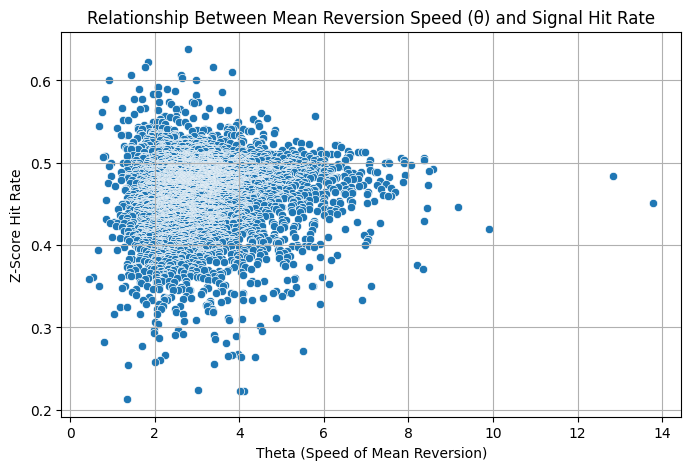

In [30]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='theta', y='Hit Rate')
plt.title("Relationship Between Mean Reversion Speed (θ) and Signal Hit Rate")
plt.xlabel("Theta (Speed of Mean Reversion)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()

In [31]:
correlation = hit_analysis_df[['theta', 'Hit Rate']].corr().iloc[0,1]
print(f"Correlation between theta and Hit Rate: {correlation:.4f}")

Correlation between theta and Hit Rate: 0.0845


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_4977/1481751874.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Relationship Between Long-Term Mean ($\mu$) and Hit Rate")


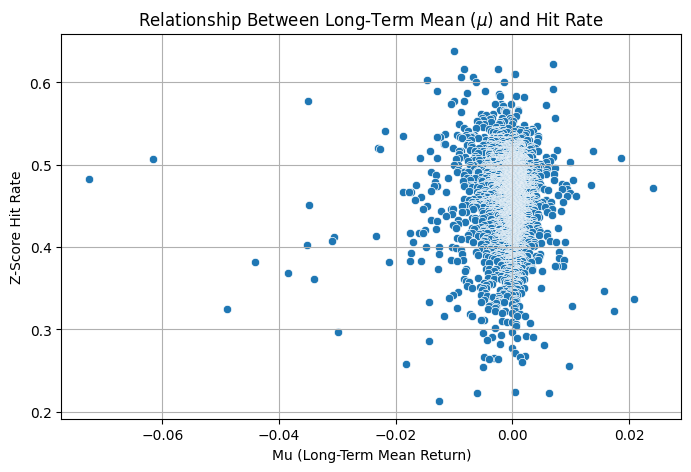

In [32]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='mu', y='Hit Rate')
plt.title("Relationship Between Long-Term Mean ($\mu$) and Hit Rate")
plt.xlabel("Mu (Long-Term Mean Return)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()


In [33]:
correlation_mu = hit_analysis_df[['mu', 'Hit Rate']].corr().iloc[0, 1]
print(f"Correlation between mu and Hit Rate: {correlation_mu:.4f}")


Correlation between mu and Hit Rate: 0.0200


In [34]:
from scipy.stats import binomtest

In [35]:
# 'valid_data' has 'permno' and 'hit_correct' columns

# Calculate total trades and correct predictions per stock
hit_summary = valid_data.groupby('permno').agg(
    correct_predictions=('hit_correct', 'sum'),
    total_trades=('hit_correct', 'count')
).reset_index()

# Calculate p-values for each stock
hit_summary['p_value'] = hit_summary.apply(
    lambda row: binomtest(int(row['correct_predictions']), int(row['total_trades']), p=0.5, alternative='greater').pvalue,
    axis=1
)

# Filter for statistically significant stocks
significant_stocks = hit_summary[hit_summary['p_value'] < 0.05]

significant_stocks

,permno,correct_predictions,total_trades,p_value
738,12044,38,61,0.036089
841,12364,207,376,0.028115
946,13019,37,58,0.023970
1058,13598,337,627,0.033057
1107,13827,73,122,0.018439
...,...,...,...,...
11642,92775,1273,2452,0.030172
11697,93071,476,873,0.004128
11699,93079,591,1101,0.007935
11769,93387,29,45,0.036227


In [36]:
significance_rate = (hit_summary['p_value'] < 0.05).mean() * 100
print(f"Percentage of Stocks with Significant Hit Rates: {significance_rate:.2f}%")


Percentage of Stocks with Significant Hit Rates: 0.55%


In [37]:
hit_summary

,permno,correct_predictions,total_trades,p_value
0,10010,493,1233,1.000000
1,10011,351,890,1.000000
2,10012,1026,2448,1.000000
3,10015,31,112,1.000000
4,10016,668,1534,1.000000
...,...,...,...,...
11780,93428,878,1886,0.998726
11781,93429,1032,1946,0.003990
11782,93433,96,186,0.357006
11783,93435,30,61,0.600924


In [38]:
df_merged.columns

Index(['date', 'permno', 'ticker', 'prc', 'retx', 'shrout', 'cfacpr', 'vol',
       'vwretd', 'vwretx', 'trading_start', 'group_id', 'adv20', 'adj_prc',
       'rolling_vol_20d_daily', 'rolling_vol_20d', 'garch_vol',
       'garch_vol_annualized', 'realized_vol_5d', 'rolling_vol_5d_daily',
       'rolling_vol_10d_daily', 'theta', 'mu', 'ou_forecast_return', 'z_ou',
       'future_return_1d', 'z_classical_5d', 'z_classical_5d_shifted',
       'z_ou_shifted', 'z_classical_10d', 'z_classical_10d_shifted',
       'z_classical_20d', 'z_classical_20d_shifted',
       'ou_forecast_with_volatility', 'z_ou_with_volatility',
       'z_ou_with_volatility_shifted'],
      dtype='object')

### 📖 Analysis: Investigating the Impact of GARCH Volatility on Trading Signal Accuracy 

In this analysis, we explore whether the level of GARCH-estimated volatility has any relationshp with the accuracy of trading signals generated using classical SD based z-scores.

- Calculate the correctness of each prediction by comparing the predicted return direction (from lagged z-scores) with the actual future return.
- Use GARCH volatility to segment the data into 10 equal-sized buckets (deciles), from lowest to highest volatility periods.
- Calculate and plot the hit rate for each volatility decile to observe how signal accuracy changes with market volatility.


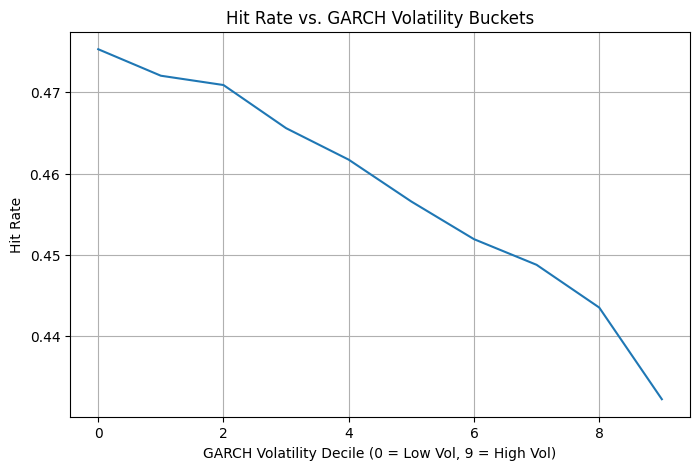

In [39]:
# Remove rows with missing data
valid_data = df_merged.dropna(subset=['z_classical_5d_shifted', 'future_return_1d']).copy()

# Calculate the hit correctness
valid_data.loc[:, 'hit_correct'] = (
    np.sign(valid_data['z_classical_5d_shifted']) == np.sign(valid_data['future_return_1d'])
).astype(int)

# Bucket GARCH volatility within valid_data only (not df_merged)
valid_data.loc[:, 'garch_vol_bucket'] = pd.qcut(valid_data['garch_vol'], q=10, labels=False)

# Calculate hit rate by GARCH volatility bucket
hit_rate_by_vol = valid_data.groupby('garch_vol_bucket')['hit_correct'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.lineplot(data=hit_rate_by_vol, x='garch_vol_bucket', y='hit_correct')
plt.xlabel("GARCH Volatility Decile (0 = Low Vol, 9 = High Vol)")
plt.ylabel("Hit Rate")
plt.title("Hit Rate vs. GARCH Volatility Buckets")
plt.grid(True)
plt.show()

Even though there is a clear signal that decrease in the GARCH volatility Decile shows strong z-score direction, hit rate is still below 50% for the first decile. So, let's create 100 quantile-based buckets to get clear overview

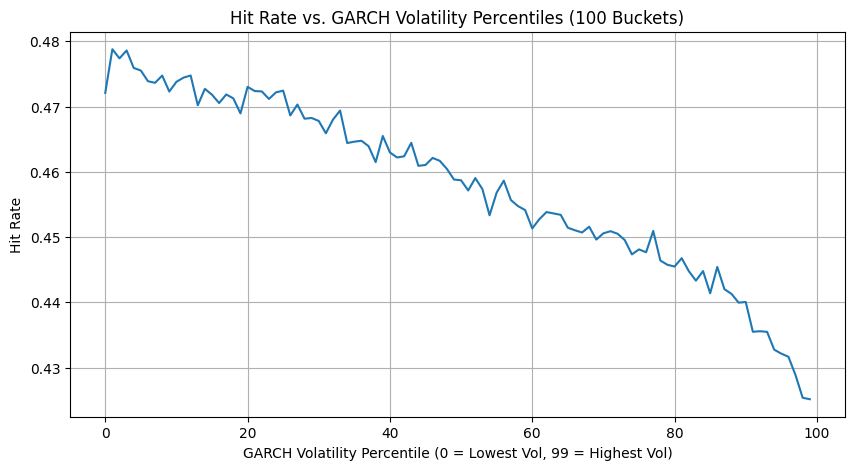

In [40]:
# Create 100 quantile-based buckets
valid_data.loc[:, 'garch_vol_bucket_100'] = pd.qcut(valid_data['garch_vol'], q=100, labels=False)

# Calculate hit rate by the new 100 buckets
hit_rate_by_vol_100 = valid_data.groupby('garch_vol_bucket_100')['hit_correct'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=hit_rate_by_vol_100, x='garch_vol_bucket_100', y='hit_correct')
plt.xlabel("GARCH Volatility Percentile (0 = Lowest Vol, 99 = Highest Vol)")
plt.ylabel("Hit Rate")
plt.title("Hit Rate vs. GARCH Volatility Percentiles (100 Buckets)")
plt.grid(True)
plt.show()

### 📊 Summary 

Even though theres is no significant difference between 100 quantile hit rates and 10 deciles hit rate, the charts clearly shows that as GARCH volatility increases, the hit rate of our trading signals declines. This indicates that our z-score signals are more effective in **low volatility environments** and tend to perform poorly during **high volatility periods**.

#### ✅ **Implications for Modeling:**
- **Trade Filtering:**  
  Execute trades only when GARCH volatility is within lower deciles (e.g., 0–3), avoiding high volatility periods where signals are less reliable.
  
- **Position Sizing:**  
  Apply **inverse volatility weighting** to allocate larger positions during low volatility regimes and smaller positions during high volatility regimes.

- **Dynamic Thresholding:**  
  Adjust z-score entry thresholds based on volatility regimes—require stronger signals during high volatility periods to reduce false positives.

Incorporating GARCH volatility into the trading framework allows for better risk management and enhances the effectiveness of mean-reversion strategies by focusing on periods where the strategy has historically performed better.

### **Mean Reversion Analysis**
### For further analysis let's only take relavant columns and non nan rows

In [41]:
# Required columns
required_columns = ['rolling_vol_5d_daily', 'garch_vol', 'garch_vol_annualized', 
                    'z_classical_5d', 'z_classical_5d_shifted']

# Filter columns that have 0 nulls and are in required_columns
columns_with_no_null = df_merged.columns[(df_merged.isnull().sum() == 0)]
print(columns_with_no_null)
final_columns = required_columns + list(columns_with_no_null)

# Final filtered DataFrame
df_filtered = df_merged[final_columns]

df_filtered = df_filtered.dropna()

df_filtered.isnull().sum()

Index(['date', 'permno', 'prc', 'retx', 'shrout', 'cfacpr', 'vol', 'vwretd',
       'vwretx', 'trading_start', 'group_id', 'adv20', 'adj_prc'],
      dtype='object')


rolling_vol_5d_daily      0
garch_vol                 0
garch_vol_annualized      0
z_classical_5d            0
z_classical_5d_shifted    0
date                      0
permno                    0
prc                       0
retx                      0
shrout                    0
cfacpr                    0
vol                       0
vwretd                    0
vwretx                    0
trading_start             0
group_id                  0
adv20                     0
adj_prc                   0
dtype: int64

In [42]:
df_filtered

,rolling_vol_5d_daily,garch_vol,garch_vol_annualized,z_classical_5d,z_classical_5d_shifted,date,permno,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start,group_id,adv20,adj_prc
3,0.054892,0.092402,1.466841,-0.040347,0.358219,1987-10-06,10010,2.2500,-0.027027,6688.0,1.35762,194.00,-0.021636,-0.021648,1987-10-01,1987-Q3-00,267.1575,1.657312
4,0.047557,0.090384,1.434795,-0.049890,-0.040347,1987-10-07,10010,2.1875,-0.027778,6688.0,1.35762,123.00,-0.003690,-0.003700,1987-10-01,1987-Q3-00,246.6375,1.611276
5,0.023063,0.088473,1.404464,0.234376,-0.049890,1987-10-08,10010,2.1875,0.000000,6688.0,1.35762,53.00,-0.012758,-0.012871,1987-10-01,1987-Q3-00,210.0275,1.611276
6,0.034519,0.086620,1.375054,1.641851,0.234376,1987-10-09,10010,2.3125,0.057143,6688.0,1.35762,74.50,-0.007670,-0.008409,1987-10-01,1987-Q3-00,190.7525,1.703349
7,0.042292,0.084765,1.345598,-1.033557,1.641851,1987-10-12,10010,2.1875,-0.054054,6688.0,1.35762,99.00,-0.007203,-0.007203,1987-10-01,1987-Q3-00,189.9025,1.611276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271433,0.058906,0.044281,0.702932,1.351523,0.759197,2024-12-24,93436,462.2800,0.073572,3210060.0,1.00000,593515.06,0.010566,0.010521,2024-10-01,2024-Q3-00,875876.6060,462.280000
13271434,0.042643,0.043815,0.695535,-0.577396,1.351523,2024-12-26,93436,454.1300,-0.017630,3210060.0,1.00000,763922.73,0.000346,0.000282,2024-10-01,2024-Q3-00,883066.3580,454.130000
13271435,0.049697,0.044679,0.709258,-0.973385,-0.577396,2024-12-27,93436,431.6600,-0.049479,3210060.0,1.00000,823703.45,-0.010692,-0.010775,2024-10-01,2024-Q3-00,895376.0835,431.660000
13271436,0.049427,0.044186,0.701432,-0.652152,-0.973385,2024-12-30,93436,417.4100,-0.033012,3210060.0,1.00000,647054.52,-0.009878,-0.009900,2024-10-01,2024-Q3-00,909094.5050,417.410000


In [43]:
# Calculate average return for each group_id and date
df_filtered['group_avg_return'] = df_filtered.groupby(['group_id', 'date'])['retx'].transform('mean')

# Calculate each stock's return relative to its group average
df_filtered['retx_relative'] = df_filtered['retx'] - df_filtered['group_avg_return']

In [44]:
# Rank stocks within group
df_filtered['group_rank'] = df_filtered.groupby(['group_id', 'date'])['retx'].rank()

### 📖 After Extreme Deviations

In this analysis, we investigate whether stocks that significantly deviate from their peer group’s average return (`retx_relative`) tend to mean revert in the short term.


#### 🧪 Approach

- Identify extreme values of `retx_relative` using the top and bottom 5% thresholds.
- Calculate future cumulative returns over multiple holding periods (1, 3, 5, and 10 days).
- Plot average future returns following:
  - **Long positions** (stocks that underperformed their group — bottom 5%)
  - **Short positions** (stocks that outperformed their group — top 5%)

This allows us to evaluate whether such relative return extremes are followed by price corrections, i.e., mean reversion.

In [45]:
# Define extreme thresholds (e.g., top and bottom 5% relative returns)
lower_threshold = df_filtered['retx_relative'].quantile(0.10)
upper_threshold = df_filtered['retx_relative'].quantile(0.90)

print(lower_threshold)
print(upper_threshold)

-0.034994275382064295
0.03436873568202349


In [46]:
(df_filtered['retx_relative'] > 0).mean()

np.float64(0.47945417049202804)

In [47]:
df_filtered['retx'].quantile(0.30)

np.float64(-0.011532)

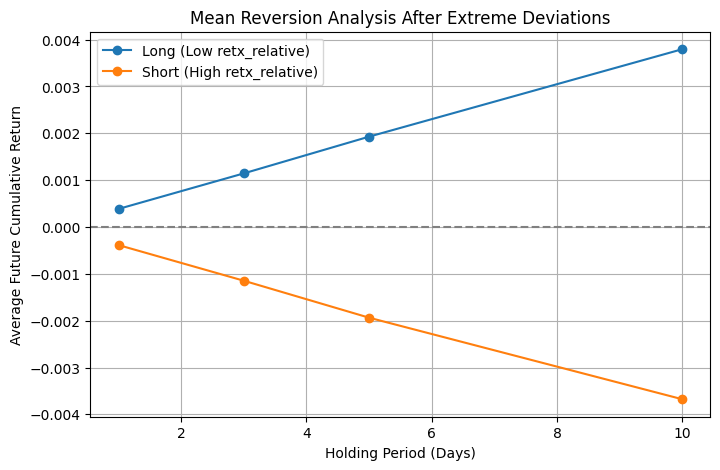

In [48]:
# Create future return columns
for h in [1, 3, 5, 10]:  # 1-day, 3-day, 5-day, and 10-day forward returns
    df_filtered[f'future_cumret_{h}d'] = df_filtered.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)

# Analyze mean future returns after extreme deviations
long_returns = df_filtered[df_filtered['retx_relative'] <= lower_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns = df_filtered[df_filtered['retx_relative'] >= upper_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plot the results
plt.figure(figsize=(8,5))
plt.plot([1, 3, 5, 10], long_returns, marker='o', label='Long (Low retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns, marker='o', label='Short (High retx_relative)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Mean Reversion Analysis After Extreme Deviations")
plt.legend()
plt.grid(True)
plt.show()


### 📊 Findings

The plot demonstrates that **mean reversion is not strongly observed** in the data:

- **Long trades** (after underperformance) generate **positive returns** and is **profitable**, but the effect is weak.
- **Short trades** (after outperformance) show **positive future returns**, meaning shorting these will generate **losses** as showin in the above graph. This indicates that previous winners tend to continue performing well.

This suggests that the market dynamics in the analyzed period exhibit **momentum behavior**, where trends persist rather than reverse.


### 📌 Implications for Strategy

- **Signal Caution:** The `retx_relative` variable alone is not sufficient to reliably capture profitable mean-reversion opportunities.
- **Market Behavior:** Short-term momentum seems to dominate, especially within peer groups, reducing the effectiveness of a pure mean-reversion strategy.

#### Lets only consider Low GARCH volatility periods

In [49]:
# Define low volatility as bottom 30% of GARCH volatility (you can adjust this threshold)
low_vol_threshold = df_filtered['garch_vol'].quantile(0.30)
df_low_vol = df_filtered[df_filtered['garch_vol'] <= low_vol_threshold]

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_4977/3234815891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low_vol[f'future_cumret_{h}d'] = (


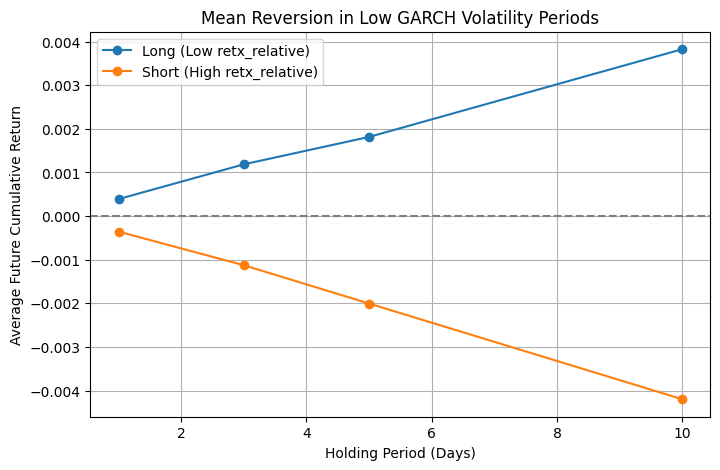

In [50]:
# Redefine thresholds for extreme deviations within low volatility periods
lower_threshold_low_vol = df_low_vol['retx_relative'].quantile(0.05)
upper_threshold_low_vol = df_low_vol['retx_relative'].quantile(0.95)

# Create future return columns if not already created
for h in [1, 3, 5, 10]:
    df_low_vol[f'future_cumret_{h}d'] = (
        df_low_vol.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)
    )

# Analyze mean future returns after extreme deviations in low volatility
long_returns_low_vol = df_low_vol[df_low_vol['retx_relative'] <= lower_threshold_low_vol][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns_low_vol = df_low_vol[df_low_vol['retx_relative'] >= upper_threshold_low_vol][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot([1, 3, 5, 10], long_returns_low_vol, marker='o', label='Long (Low retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns_low_vol, marker='o', label='Short (High retx_relative)')  # Plotting profits
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Mean Reversion in Low GARCH Volatility Periods")
plt.legend()
plt.grid(True)
plt.show()

- Even in the low vol, our short position will be generating losses. Both the underperforming and outperforming stocks tend to move in upward direction. This shows no mean reversion in KNN based peer portfolios

#### **Let's check on portfolios**
Is there any group where mean reversion might work. and if yes, how many such group exist?

In [51]:
group_analysis_results = []

for group_id, group_df in df_filtered.groupby('group_id'):
    lower_threshold = group_df['retx_relative'].quantile(0.05)
    upper_threshold = group_df['retx_relative'].quantile(0.95)
    
    long_future_return = group_df[group_df['retx_relative'] <= lower_threshold]['future_cumret_5d'].mean()
    short_future_return = group_df[group_df['retx_relative'] >= upper_threshold]['future_cumret_5d'].mean()
    
    group_analysis_results.append({
        'group_id': group_id,
        'long_avg_return_5d': long_future_return,
        'short_avg_return_5d': short_future_return
    })

group_analysis_df = pd.DataFrame(group_analysis_results)


In [52]:
# Mean reversion should have long returns > 0 and short returns < 0
mean_reversion_groups = group_analysis_df[
    (group_analysis_df['long_avg_return_5d'] > 0) & 
    (group_analysis_df['short_avg_return_5d'] < 0)
]

print(f"Number of groups where mean reversion works: {len(mean_reversion_groups)}")
display(mean_reversion_groups.sort_values(by='long_avg_return_5d', ascending=False))

Number of groups where mean reversion works: 255


,group_id,long_avg_return_5d,short_avg_return_5d
977,2007-Q3-06,0.385760,-0.010226
168,1983-Q1-02,0.080641,-0.029988
141,1981-Q4-10,0.062837,-0.064960
44,1977-Q2-04,0.042271,-0.041844
1064,2010-Q3-09,0.036940,-0.021799
...,...,...,...
1156,2013-Q4-09,0.000069,-0.002714
589,1995-Q3-10,0.000063,-0.003909
1252,2017-Q2-09,0.000036,-0.004643
511,1993-Q3-02,0.000032,-0.000294


In [53]:
total_groups = group_analysis_df['group_id'].nunique()
mean_reversion_groups_count = len(mean_reversion_groups)

# Calculate percentage
mean_reversion_percentage = (mean_reversion_groups_count / total_groups) * 100

print(f"📊 Total Groups Analyzed: {total_groups}")
print(f"✅ Groups Showing Mean Reversion: {mean_reversion_groups_count}")
print(f"📈 Percentage of Groups with Mean Reversion: {mean_reversion_percentage:.2f}%")


📊 Total Groups Analyzed: 1442
✅ Groups Showing Mean Reversion: 255
📈 Percentage of Groups with Mean Reversion: 17.68%


In [54]:
# Extract year from group_id (assuming it's like '1976-Q1-07')
mean_reversion_groups['year'] = mean_reversion_groups['group_id'].str[:4]

# Calculate how many groups showed mean reversion per year
mean_reversion_by_year = mean_reversion_groups.groupby('year').size().reset_index(name='mean_reversion_groups')

# Also calculate total groups per year for percentage calculation
group_analysis_df['year'] = group_analysis_df['group_id'].str[:4]
total_groups_by_year = group_analysis_df.groupby('year').size().reset_index(name='total_groups')

# Merge and calculate percentage
yearly_stats = pd.merge(mean_reversion_by_year, total_groups_by_year, on='year')
yearly_stats['mean_reversion_percentage'] = (yearly_stats['mean_reversion_groups'] / yearly_stats['total_groups']) * 100
yearly_stats

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_4977/4061635517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_reversion_groups['year'] = mean_reversion_groups['group_id'].str[:4]


,year,mean_reversion_groups,total_groups,mean_reversion_percentage
0,1975,1,21,4.761905
1,1976,4,19,21.052632
2,1977,3,13,23.076923
3,1978,1,16,6.250000
4,1979,4,23,17.391304
5,1980,6,23,26.086957
6,1981,6,27,22.222222
7,1982,5,24,20.833333
8,1983,7,33,21.212121
9,1984,2,32,6.250000


There are only 17.68% group where mean reversion would work. There's also atleast 1 group every year where mean reversion would work.

### **Now, let's look for trend following strategy**

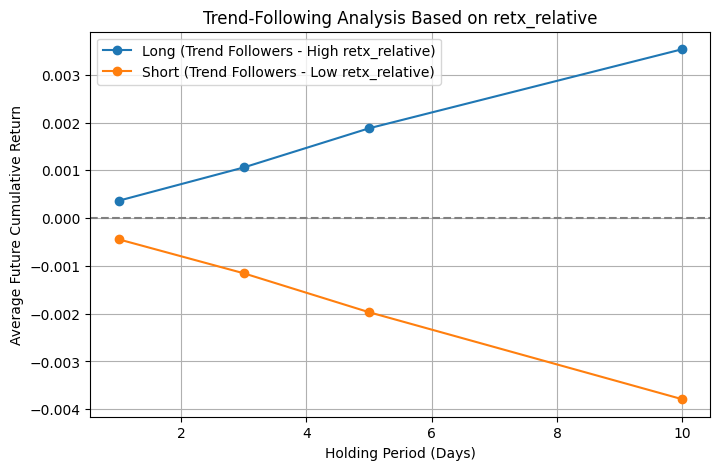

In [55]:
# Define thresholds for identifying trending stocks
lower_threshold = df_filtered['retx_relative'].quantile(0.05)  # Underperformers (trend-following short)
upper_threshold = df_filtered['retx_relative'].quantile(0.95)  # Outperformers (trend-following long)

# Ensure future returns are calculated
for h in [1, 3, 5, 10]:
    df_filtered[f'future_cumret_{h}d'] = (
        df_filtered.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)
    )

# Analyze mean future returns after extreme performance (trend-following)
long_returns_trend = df_filtered[df_filtered['retx_relative'] >= upper_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns_trend = df_filtered[df_filtered['retx_relative'] <= lower_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot([1, 3, 5, 10], long_returns_trend, marker='o', label='Long (Trend Followers - High retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns_trend, marker='o', label='Short (Trend Followers - Low retx_relative)')  # Profit perspective
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Trend-Following Analysis Based on retx_relative")
plt.legend()
plt.grid(True)
plt.show()

Even in trend following our short positions doesn't generate profit. Seems not working.

In [56]:
short_returns_trend

future_cumret_1d     0.000443
future_cumret_3d     0.001155
future_cumret_5d     0.001969
future_cumret_10d    0.003790
dtype: float64